In [5]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

# Multilayer-Perceptron and Images

## Goals

- Train an MLP and understand how it works on images

## Setup

Let's define paths, install & load the necessary Python packages.

**Optionally: Save the notebook to your personal google drive to persist changes.**

Mount your google drive to store data and results (if running the code in Google Colab).

In [6]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [7]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

**Modify the following paths if necessary.**

That is where your data will be stored.

In [8]:
from pathlib import Path

if IN_COLAB:
    DATA_PATH = Path("/content/drive/MyDrive/bveri")
else:
    DATA_PATH = Path("/workspace/code/data")

Install the package `dl_cv_lectures`.

The following code installs the package from a local repository (if available), otherwise it installs it from the exercise repository.

In [9]:
try:
    import dl_cv_lectures

    print("dl_cv_lectures installed, all good")
except ImportError as e:
    import os

    if Path("/workspace/code/src").exists():
        print("Installing from local repo")
        os.system("cd /workspace/code  && pip install .")
    else:
        print("Installing from git repo")
        os.system("pip install git+https://github.com/i4Ds/bveri-exercises-hs2024")

dl_cv_lectures installed, all good


Load all packages

In [10]:
import math
import random
from typing import Callable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torchshow as ts
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torchvision import transforms
from torchvision.transforms.v2 import functional as TF
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

Define a default device for your computations.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cpu


## 1) Define Data, Loaders, and MLP

Quickly get data and train an MLP.

We use some pre-defined functionality from the `dl_cv_lectures` package. Feel free to substitute with your own functionality. 

In [12]:
from dl_cv_lectures import visualize
from dl_cv_lectures.classification import train_one_epoch
from dl_cv_lectures.data import pattern

## Data

We use a dataset that consists of inspection images of microscopic components. Some of them are faulty (label=1) and need to be identified and sorted out.

Lets load the data and take a look at it.

First we create a [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).

In [13]:
ds_train = pattern.PatternDataset(
    num_samples=100, image_side_length=16, seed=123, max_errors=3, max_x_y_shift=0
)

Let's take a look at the first observation.

In [14]:
image, label = ds_train[0]
image.size
image

(16, 16)

We collect a few samples, visualize them and try to understand how label and images are related.

In [15]:
def get_images_and_labels_from_ds(
    ds: torch.utils.data.Dataset, num_images_to_fetch: int = 16
) -> list[torch.Tensor]:
    """Fetch first n images from a torch.utils.data.Dataset with (image, label) signature."""
    # for each image: convert it to (C x H x W) format and scale to 0-1
    images = [
        TF.to_image(ds[i][0]).to(torch.float32) / 255.0
        for i in range(0, num_images_to_fetch)
    ]
    labels = [ds[i][1] for i in range(0, num_images_to_fetch)]
    return images, labels

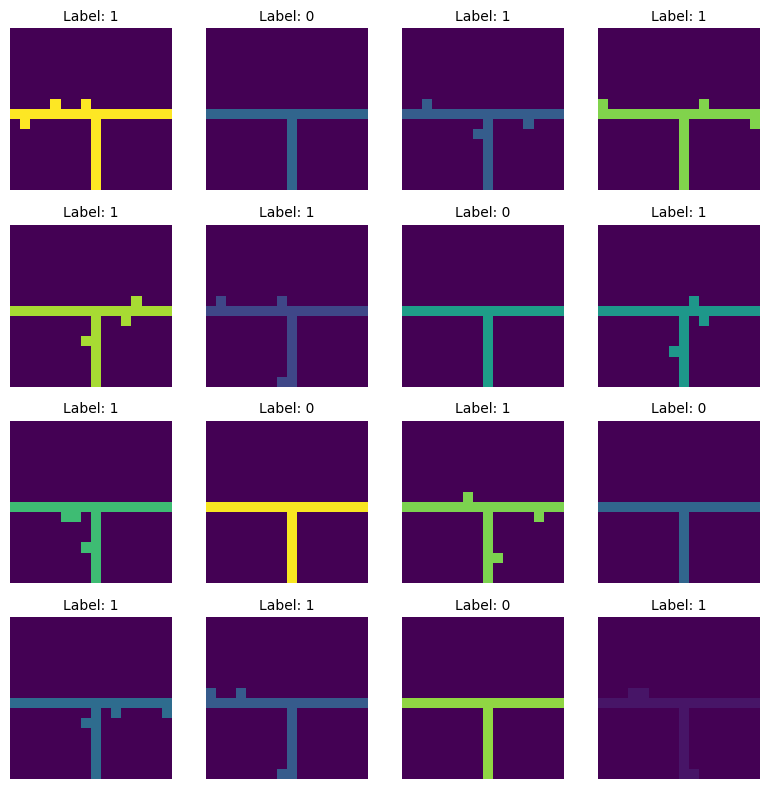

In [16]:
images, labels = get_images_and_labels_from_ds(ds_train, num_images_to_fetch=16)

fig, ax = visualize.plot_square_collage_with_captions(
    images, [f"Label: {label}" for label in labels], global_normalize=True
)
plt.tight_layout()

**Question**: When is a pattern label=0, when is it label=1?

The pattern has a label of 0 when it is not T-shaped else it is 1 

## MLP Architecture

Next, we define an MLP.

In [17]:
class MLP(nn.Module):
    """A Multi-Layer Perceptron (MLP) model for classification."""

    def __init__(
        self,
        num_hidden: int,
        num_classes: int,
        input_size: tuple[int, int, int] = (1, 28, 28),
    ):
        """
        Args:
            num_hidden (int): Number of neurons in the hidden layer.
            num_classes (int): Number of output classes for classification.
            input_size tuple[int, int, int]: The dimensions of the input image.
        """
        super().__init__()
        # Flatten the input image into a 1D tensor
        self.flatten = nn.Flatten()

        # Hidden layer: fully connected layer from input_size to num_hidden neurons.
        self.hidden = nn.Linear(
            in_features=input_size[0] * input_size[1] * input_size[2],
            out_features=num_hidden,
            bias=True,
        )

        # Output layer: fully connected layer from num_hidden neurons to num_classes outputs.
        self.output = nn.Linear(in_features=num_hidden, out_features=num_classes)

    def forward(self, x):
        """
        Forward pass through the MLP model.

        Args:
            x (torch.Tensor): Input tensor (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output logits (before softmax).
        """
        # Flatten the input tensor into (batch_size, input_size[0] * input_size[1])
        x = self.flatten(x)

        # Apply the hidden layer (linear transformation)
        x = self.hidden(x)

        # Apply ReLU activation function to introduce non-linearity
        x = F.relu(x)

        # Apply the output layer (linear transformation) to get the logits
        x = self.output(x)

        # Return the output logits (not yet passed through softmax)
        return x

Lets initialize the model and inspect it using `torchinfo`

In [18]:
torch.manual_seed(123)
net = MLP(num_hidden=16, num_classes=2, input_size=(1, 16, 16))
print(net)
print(torchinfo.summary(net, input_size=(1, 1, 16, 16)))

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=256, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 2]                    --
├─Flatten: 1-1                           [1, 256]                  --
├─Linear: 1-2                            [1, 16]                   4,112
├─Linear: 1-3                            [1, 2]                    34
Total params: 4,146
Trainable params: 4,146
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02


Now we define loss function and optimizer.

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1, weight_decay=1e-3)

Next, we define the training dataset and dataloader.

In [20]:
image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


ds_train = pattern.PatternDataset(
    num_samples=100000,
    seed=123,
    max_errors=3,
    max_x_y_shift=0,
    transform=image_transforms,
)

dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=128, shuffle=True, num_workers=4
)

## Model Training

That's it! We are ready to train our model.

In [21]:
total_epochs = 3
for epoch in range(0, total_epochs):
    print(f"Starting Epoch: {epoch + 1} / {total_epochs}")
    train_one_epoch(dl_train, net, optimizer, loss_fn, device=device)

Starting Epoch: 1 / 3


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 2 / 3


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 3 / 3


  0%|          | 0/782 [00:00<?, ?batch/s]

## 2) Analyse MLP properties

Now it is getting interesting! 

We want to inspect the weights of the MLP.

We can access the layers of our model by the attributes that we defined.

For example we can access the attribute `hidden` of our `MLP`  object.

In [22]:
weights = net.hidden.weight
weights.shape

torch.Size([16, 256])

The weight matrix $\mathbf{W}$ is multiplied with an image $\mathbf{x}$ to produce the layer activations $\mathbf{a}$ with: $\mathbf{a} = \mathbf{x} \mathbf{W}^T + \mathbf{b}$

We can see that the hidden layer has 16 neurons, each of which is connected to all input neurons.

Each row in $\mathbf{W}$ can be visualized as an image. We need to reshape it accordingly.

**Question**: What do you expect to see when visualizing the weights?

I expect to see maybe simple shapes but nothing sensible because the weights of 1 Hidden Layer can't grasp much of the image

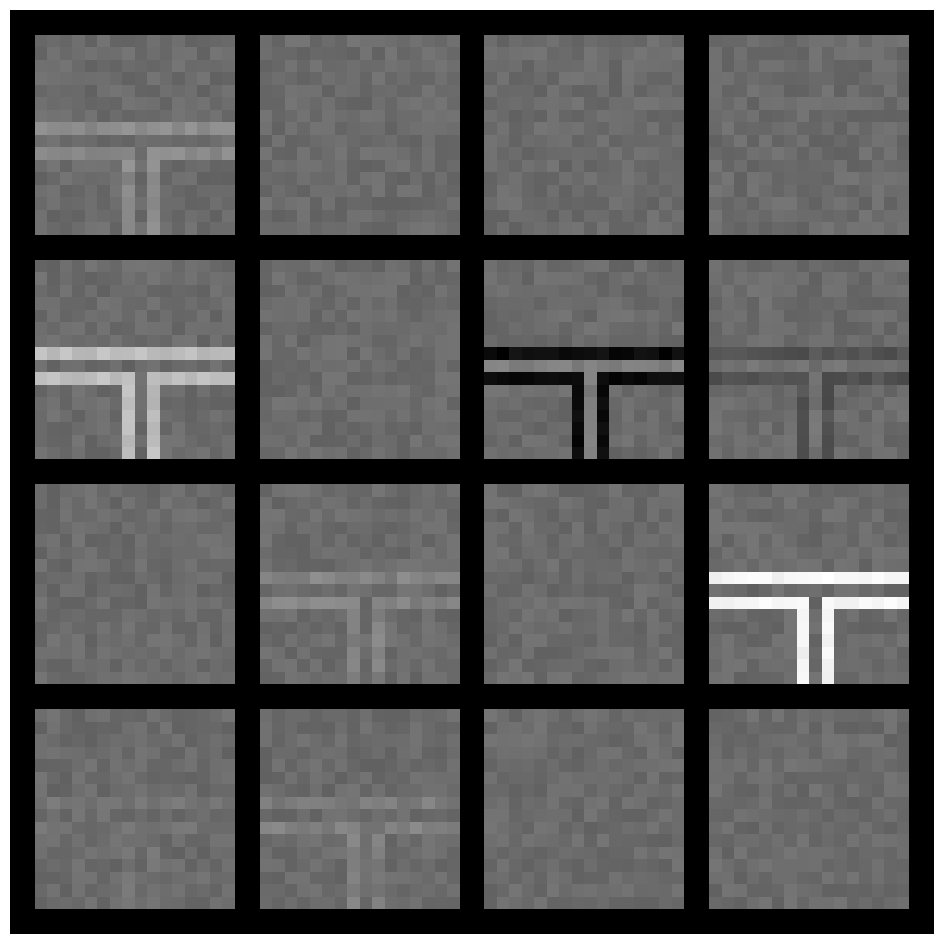

In [23]:
def visualize_weights(
    weights: torch.Tensor, figsize: tuple[int, int] = (12, 12), scale_each: bool = True
):
    num_neurons = weights.shape[0]
    dim = weights.shape[1]

    side_length = int(math.sqrt(dim))

    weights = weights.reshape(num_neurons, 1, side_length, side_length)

    nrow = int(math.sqrt(num_neurons))
    image_grid = TF.to_pil_image(
        make_grid(weights, nrow=nrow, normalize=True, scale_each=scale_each)
    )

    fig, ax = plt.subplots(figsize=figsize)
    _ = ax.imshow(image_grid, cmap="Greys_r")
    _ = ax.axis("off")
    plt.show()


visualize_weights(weights, scale_each=False)

**Question**: How do you interpret the weights? How does it match with your expectations?

The weights pick up on the shapes of the pattern. It also picks up on the lighting with some weights having a strong white Patterns and others having strong black.

**Question**: What happens if we reduce the hidden layer to just 2 neurons?

In [24]:
torch.manual_seed(123)
net = MLP(num_hidden=2, num_classes=2, input_size=(1, 16, 16))
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=128, shuffle=True, num_workers=4
)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1, weight_decay=1e-3)
total_epochs = 5
for epoch in range(0, total_epochs):
    print(f"Starting Epoch: {epoch + 1} / {total_epochs}")
    train_one_epoch(dl_train, net, optimizer, loss_fn)

Starting Epoch: 1 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 2 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 3 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 4 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 5 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

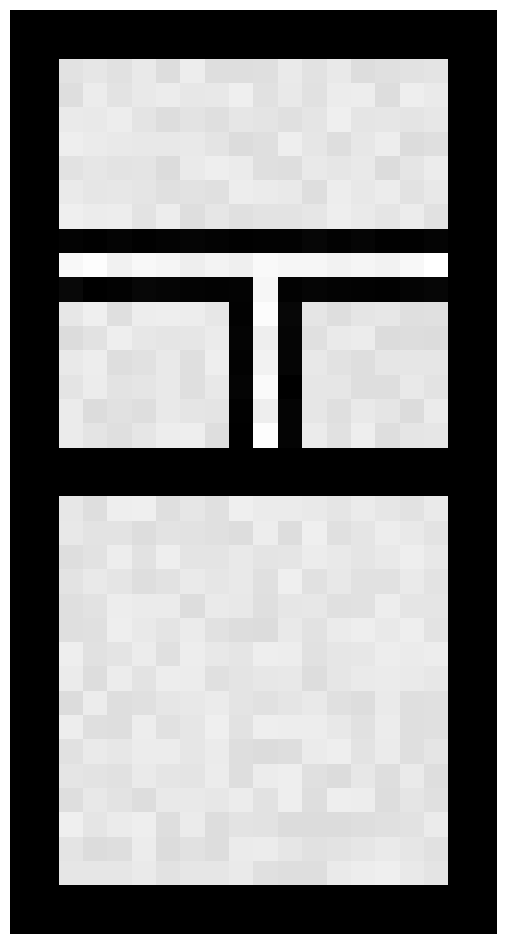

In [25]:
visualize_weights(net.hidden.weight, scale_each=False)

# 3) What if?

What if we make it a bit more difficult and let the pattern randomly shift spatially?

In [26]:
ds_train = pattern.PatternDataset(
    num_samples=100000, seed=123, max_errors=3, max_x_y_shift=1
)

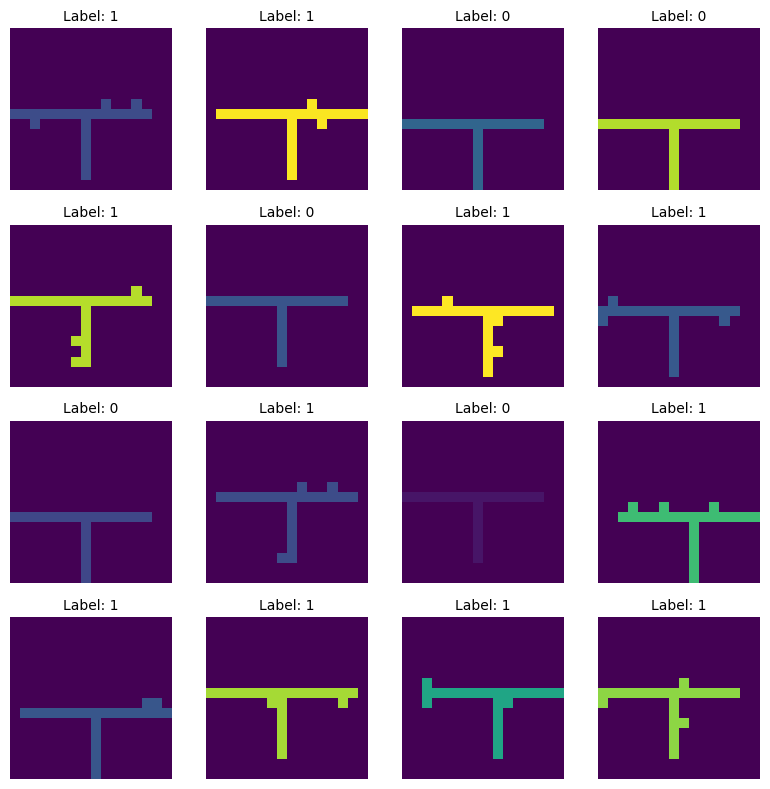

In [27]:
images, labels = get_images_and_labels_from_ds(ds_train, num_images_to_fetch=16)

fig, ax = visualize.plot_square_collage_with_captions(
    images, [f"Label: {label}" for label in labels], global_normalize=True
)
plt.tight_layout()

**Question**: Is this a more difficult problem? How will the weights differ from the simpler case?

This is a more difficult problem because all the pixel values changes and the neural network has to pick up more nuisances of the image

In [28]:
torch.manual_seed(123)
net = MLP(num_hidden=16, num_classes=2, input_size=(1, 16, 16))
ds_train = pattern.PatternDataset(
    num_samples=100000,
    seed=123,
    max_errors=3,
    max_x_y_shift=1,
    transform=image_transforms,
)
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=128, shuffle=True, num_workers=4
)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1, weight_decay=1e-3)
total_epochs = 5
for epoch in range(0, total_epochs):
    print(f"Starting Epoch: {epoch + 1} / {total_epochs}")
    train_one_epoch(dl_train, net, optimizer, loss_fn)

Starting Epoch: 1 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 2 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 3 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 4 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 5 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

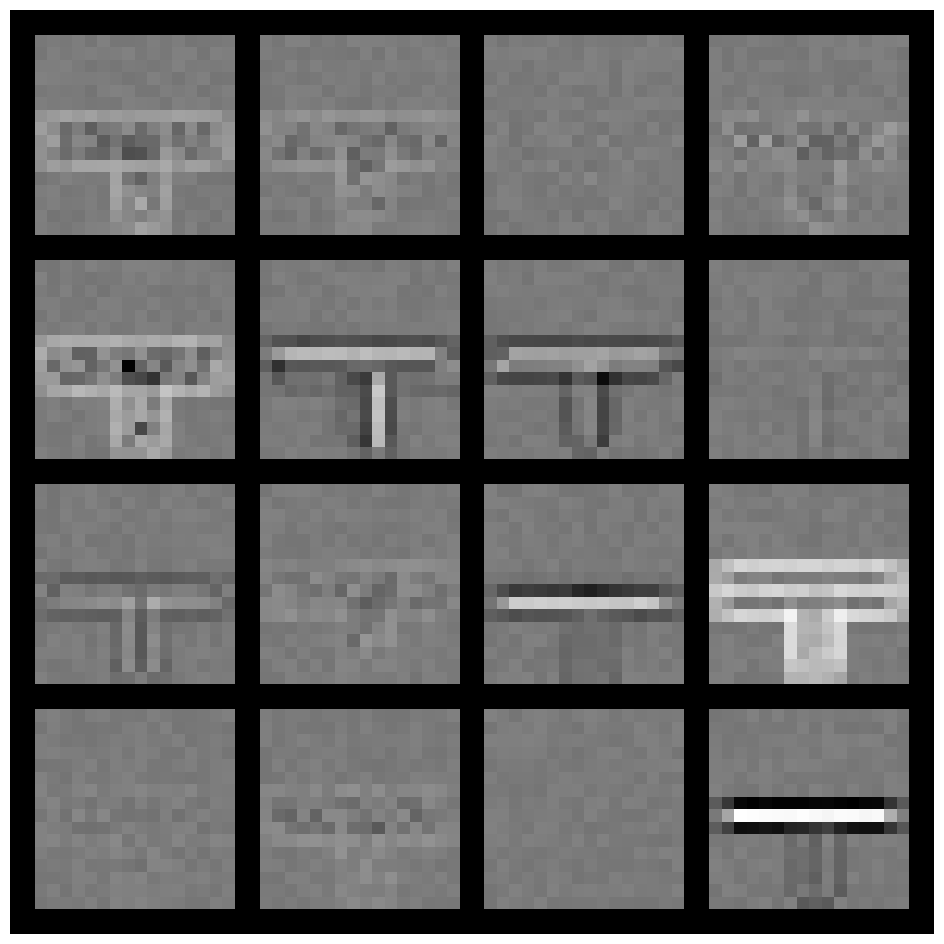

In [29]:
visualize_weights(net.hidden.weight, scale_each=False)

This is already a bit more difficult to interpret!

## 4) Let's try somethig more crazy!

We extend the images and place each pattern in a random quarant.

In [30]:
from dl_cv_lectures.transform import RandomQuadrantPad

torch.manual_seed(123)
ds_train = pattern.PatternDataset(
    num_samples=100000,
    seed=123,
    max_errors=3,
    max_x_y_shift=0,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            RandomQuadrantPad(),
            transforms.Lambda(lambda x: TF.to_pil_image(x)),
        ]
    ),
)

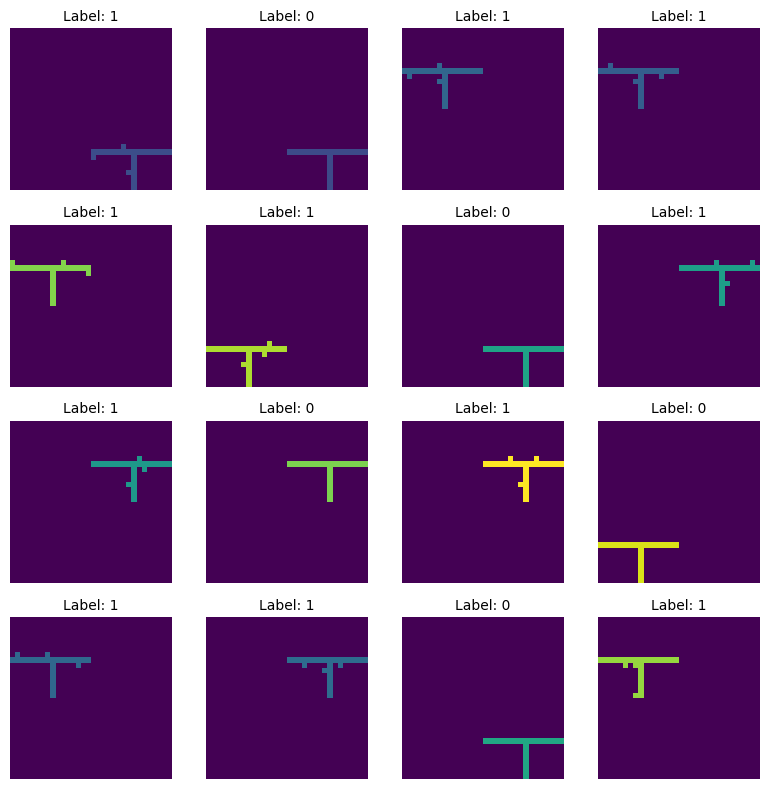

In [31]:
images, labels = get_images_and_labels_from_ds(ds_train, num_images_to_fetch=16)

fig, ax = visualize.plot_square_collage_with_captions(
    images, [f"Label: {label}" for label in labels], global_normalize=True
)
plt.tight_layout()

**Question**: What do you think happens here?

In [32]:
torch.manual_seed(123)
net = MLP(num_hidden=16, num_classes=2, input_size=(1, 16 * 2, 16 * 2))
ds_train = pattern.PatternDataset(
    num_samples=100000,
    seed=123,
    max_errors=3,
    max_x_y_shift=0,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            RandomQuadrantPad(),
        ]
    ),
)
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=128, shuffle=True, num_workers=4
)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1, weight_decay=1e-3)
total_epochs = 5
for epoch in range(0, total_epochs):
    print(f"Starting Epoch: {epoch + 1} / {total_epochs}")
    train_one_epoch(dl_train, net, optimizer, loss_fn)

Starting Epoch: 1 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 2 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 3 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 4 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 5 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

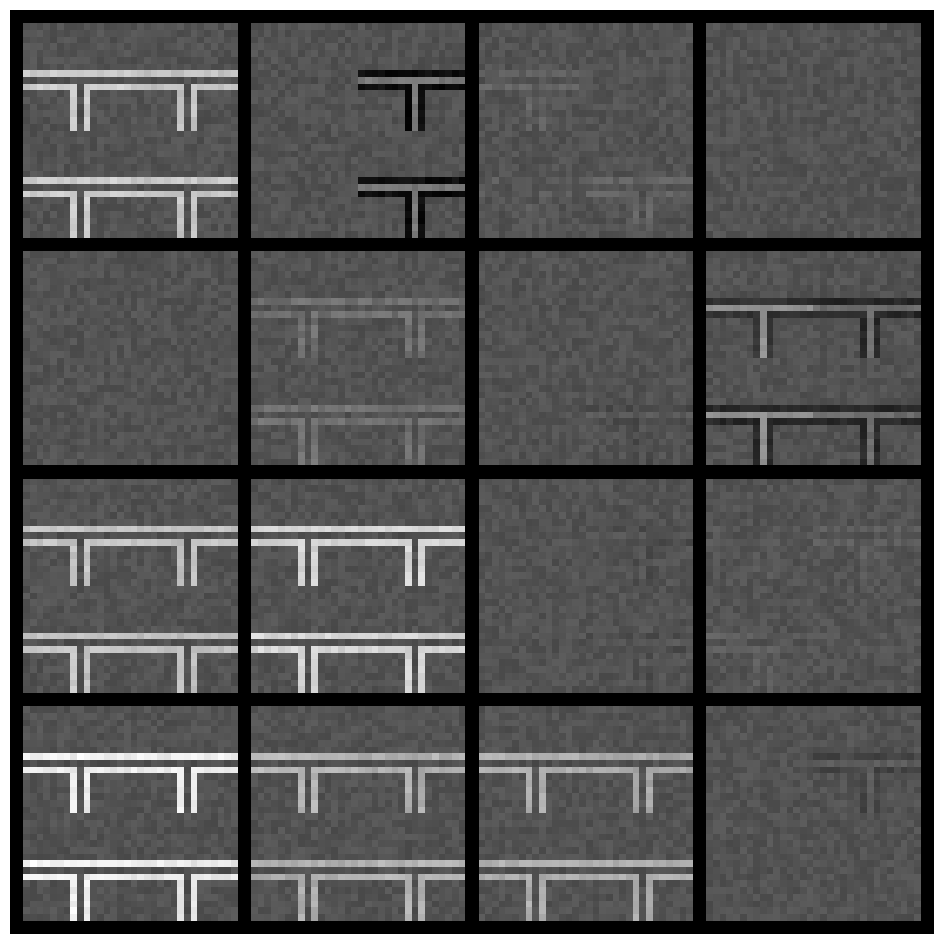

In [33]:
visualize_weights(net.hidden.weight, scale_each=False)

## 5) What happens if we increase the positional uncertainty?

Let's randomly shift the pattern by up to 3 pixels.

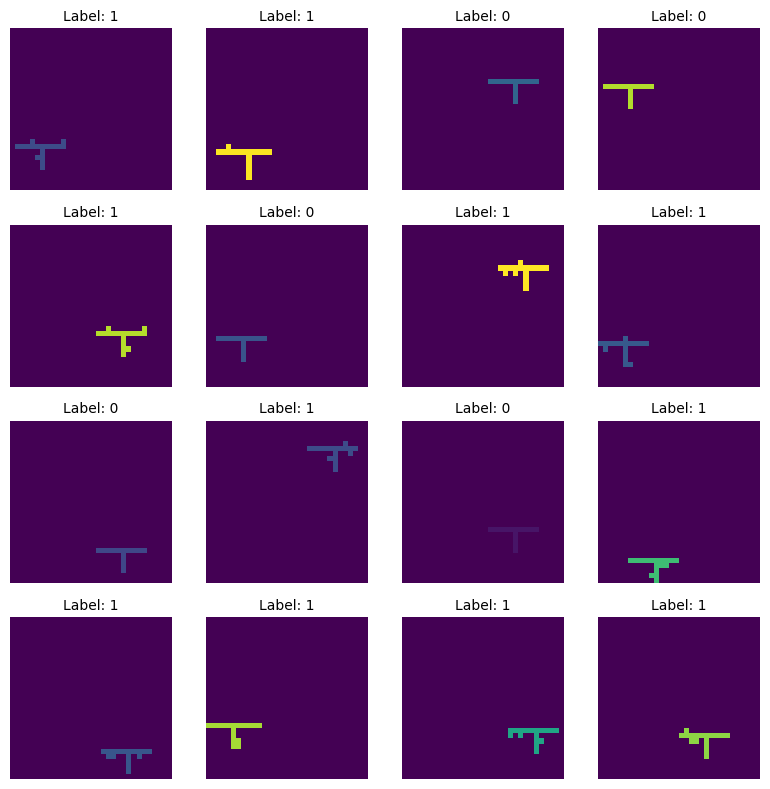

In [34]:
torch.manual_seed(123)
ds_train = pattern.PatternDataset(
    num_samples=100000,
    seed=123,
    max_errors=3,
    max_x_y_shift=3,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            RandomQuadrantPad(),
            transforms.Lambda(lambda x: TF.to_pil_image(x)),
        ]
    ),
)

images, labels = get_images_and_labels_from_ds(ds_train, num_images_to_fetch=16)

fig, ax = visualize.plot_square_collage_with_captions(
    images, [f"Label: {label}" for label in labels], global_normalize=True
)
plt.tight_layout()

We switch to the Adam optimizer which is often much faster and needs less care tuning learning rates.

In [35]:
torch.manual_seed(123)
net = MLP(num_hidden=16, num_classes=2, input_size=(1, 16 * 2, 16 * 2))
ds_train = pattern.PatternDataset(
    num_samples=100000,
    seed=123,
    max_errors=3,
    max_x_y_shift=3,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            RandomQuadrantPad(),
        ]
    ),
)
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=128, shuffle=True, num_workers=4
)
optimizer = torch.optim.Adam(net.parameters())
total_epochs = 5
for epoch in range(0, total_epochs):
    print(f"Starting Epoch: {epoch + 1} / {total_epochs}")
    train_one_epoch(dl_train, net, optimizer, loss_fn)

Starting Epoch: 1 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 2 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 3 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 4 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 5 / 5


  0%|          | 0/782 [00:00<?, ?batch/s]

**Question**: What do you observe?

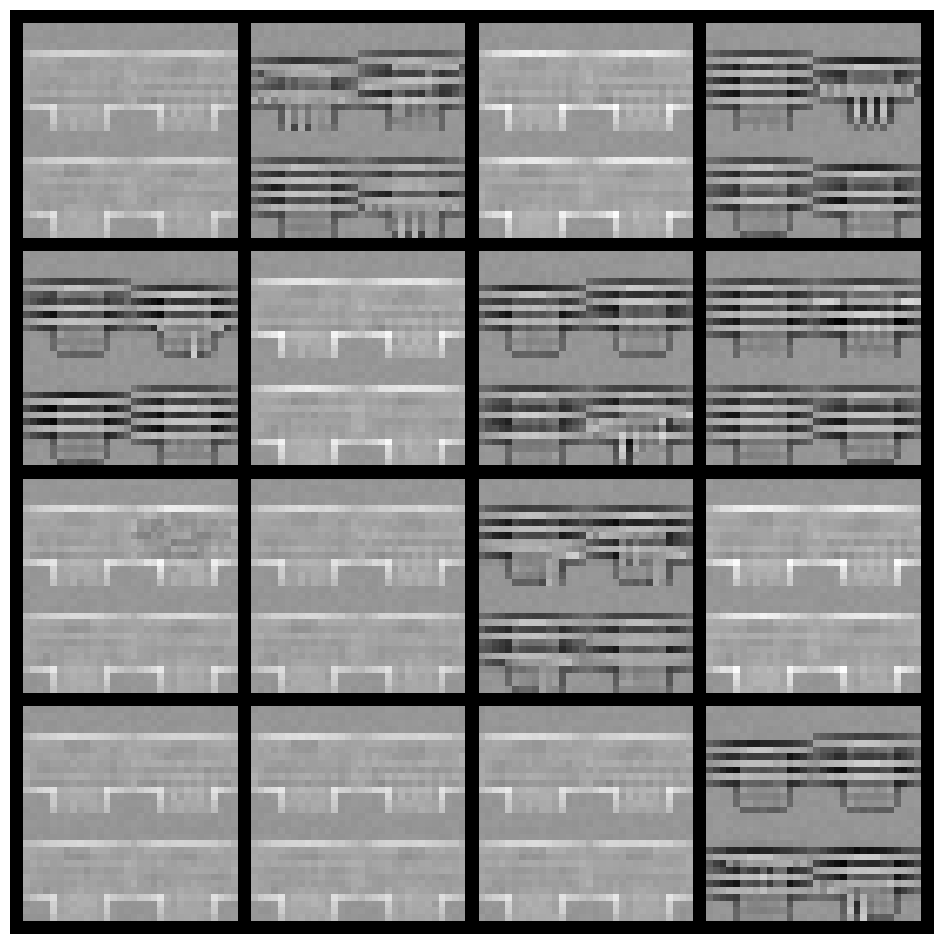

In [36]:
visualize_weights(net.hidden.weight, scale_each=False)

## 6) A Peek Ahead: What happens if we choose a CNN?

Finally! Let's ditch the MLP.

The following CNN is deeper but has 10 times fewer parameters.

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SmallCNN(nn.Module):
    def __init__(self, kernel_size: int, num_classes=10, num_filters=16):
        super(SmallCNN, self).__init__()

        padding = kernel_size // 2

        # First convolutional layer: 1 input channel (grayscale), 16 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=num_filters,
            kernel_size=kernel_size,
            padding=padding,
        )

        # Second convolutional layer: 16 input channels, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(
            in_channels=num_filters,
            out_channels=num_filters * 2,
            kernel_size=kernel_size,
            padding=padding,
        )

        # Third convolutional layer: 32 input channels, 64 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(
            in_channels=num_filters * 2,
            out_channels=num_filters * 4,
            kernel_size=kernel_size,
            padding=padding,
        )

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Output size is 1x1 per feature map

        # Final output layer
        self.fc = nn.Linear(in_features=num_filters * 4, out_features=num_classes)

    def forward(self, x):
        # First conv layer with ReLU
        x = F.relu(self.conv1(x))
        # Second conv layer with ReLU and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Third conv layer with ReLU and max pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Global Average Pooling (GAP)
        x = self.gap(x)  # Shape will be (batch_size, 64, 1, 1)

        # Flatten the GAP output to feed into the fully connected layer
        x = torch.flatten(x, 1)  # Shape (batch_size, 64)

        # Final fully connected layer (acts as the output layer)
        x = self.fc(x)  # Shape (batch_size, num_classes)

        return x

In [38]:
net = SmallCNN(kernel_size=3, num_classes=2, num_filters=2)
print(torchinfo.summary(net, input_size=(1, 1, 16 * 2, 16 * 2)))

Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [1, 2]                    --
├─Conv2d: 1-1                            [1, 2, 32, 32]            20
├─Conv2d: 1-2                            [1, 4, 32, 32]            76
├─MaxPool2d: 1-3                         [1, 4, 16, 16]            --
├─Conv2d: 1-4                            [1, 8, 16, 16]            296
├─MaxPool2d: 1-5                         [1, 8, 8, 8]              --
├─AdaptiveAvgPool2d: 1-6                 [1, 8, 1, 1]              --
├─Linear: 1-7                            [1, 2]                    18
Total params: 410
Trainable params: 410
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.07


In [39]:
torch.manual_seed(123)
net = SmallCNN(kernel_size=3, num_classes=2, num_filters=2)
ds_train = pattern.PatternDataset(
    num_samples=100000,
    seed=123,
    max_errors=3,
    max_x_y_shift=3,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            RandomQuadrantPad(),
        ]
    ),
)
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size=128, shuffle=True, num_workers=6
)
optimizer = torch.optim.Adam(net.parameters())
total_epochs = 3
for epoch in range(0, total_epochs):
    print(f"Starting Epoch: {epoch + 1} / {total_epochs}")
    train_one_epoch(dl_train, net, optimizer, loss_fn)

Starting Epoch: 1 / 3


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 2 / 3


  0%|          | 0/782 [00:00<?, ?batch/s]

Starting Epoch: 3 / 3


  0%|          | 0/782 [00:00<?, ?batch/s]

The CNN uses only two filters in the first layer, which we can visualize:

c:\Users\viety\OneDrive\Desktop\Studium\5.Semester\bverl\bveri-exercises-hs2024\.venv\Lib\site-packages\torchshow\visualization.py:388: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


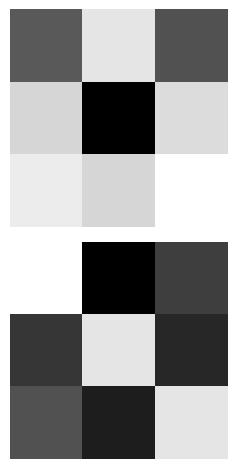

In [40]:
ts.show(net.conv1.weight)